In [128]:
import pandas as pd
import sqlite3
import numpy as np
import re
from dateutil.relativedelta import relativedelta
from datetime import date
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,ExtraTreesClassifier
from sklearn.tree import DecisionTreeRegressor,plot_tree
from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn import tree
from lazypredict.Supervised import LazyClassifier
from sklearn.metrics import accuracy_score

In [16]:
def RMSE(model, X, y):
    return np.sqrt(((model.predict(X) - y)**2).mean())

In [21]:
con = sqlite3.connect("D:/Python/ekonomia sportu/database.sqlite")

In [22]:
country_df = pd.read_sql_query("SELECT * from country", con)

In [23]:
league_df = pd.read_sql_query("SELECT * from league", con)

In [24]:
match_df = pd.read_sql_query("SELECT * from match", con)

In [25]:
player_df = pd.read_sql_query("SELECT * from player", con)

In [26]:
player_atr_df = pd.read_sql_query("SELECT * from player_attributes", con)

In [27]:
team_df = pd.read_sql_query("SELECT * from team", con)

In [28]:
team_atr_df = pd.read_sql_query("SELECT * from team_attributes", con)

In [29]:
match_df['home_team_win']=np.where((match_df['home_team_goal']-match_df['away_team_goal'])>=0,1,0)

In [30]:
df=match_df.drop(['id','BWH','BWD','BWA','IWH','IWD','IWA','LBH','LBD','LBA','PSH','PSD','PSA','WHH',
               'WHD','WHA','SJH','SJD','SJA','VCH','VCD','VCA','GBH','GBD','GBA','BSH','BSD'
               ,'BSA','B365H','B365D','B365A','home_team_goal','away_team_goal','home_player_X1',
                  'home_player_X2','home_player_X3','home_player_X4','home_player_X5','home_player_X6',
                'home_player_X7','home_player_X8','home_player_X9','home_player_X10','home_player_X11',
                  'away_player_X1','away_player_X2','away_player_X3','away_player_X4','away_player_X5',
                  'away_player_X6','away_player_X7','away_player_X8','away_player_X9','away_player_X10',
                  'away_player_X11','home_player_Y1','home_player_Y2','home_player_Y3','home_player_Y4',
                  'home_player_Y5','home_player_Y6','home_player_Y7','home_player_Y8','home_player_Y9',
                  'home_player_Y10','home_player_Y11','away_player_Y1','away_player_Y2','away_player_Y3',
                'away_player_Y4','away_player_Y5','away_player_Y6','away_player_Y7','away_player_Y8',
                  'away_player_Y9','away_player_Y10','away_player_Y11','date','season',
                  'match_api_id','goal','shoton','shotoff','foulcommit','card','cross',
                  'corner','possession'],axis=1)

In [31]:
df[df[['home_player_1','home_player_2','home_player_3','home_player_4','home_player_5',
      'home_player_6','home_player_7','home_player_8','home_player_9','home_player_10',
      'home_player_11','away_player_1','away_player_2','away_player_3','away_player_4'
      ,'away_player_5','away_player_6','away_player_7','away_player_8','away_player_9',
      'away_player_10','away_player_11']].notnull().all(1)]

,country_id,league_id,stage,home_team_api_id,away_team_api_id,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,...,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,home_team_win
145,1,1,24,8203,9987,38327.0,67950.0,67958.0,67959.0,37112.0,...,148313.0,104411.0,148314.0,37202.0,43158.0,9307.0,42153.0,32690.0,38782.0,1
153,1,1,25,9984,8342,36835.0,37047.0,37021.0,37051.0,104386.0,...,11736.0,37858.0,38366.0,37983.0,39578.0,38336.0,52280.0,27423.0,38440.0,0
155,1,1,25,8635,10000,34480.0,38388.0,26458.0,13423.0,38389.0,...,37903.0,37889.0,94030.0,37893.0,37981.0,131531.0,130027.0,38231.0,131530.0,1
162,1,1,26,8203,8635,38327.0,67950.0,67958.0,38801.0,67898.0,...,38389.0,31316.0,164694.0,30949.0,38378.0,38383.0,38393.0,38253.0,37069.0,1
168,1,1,26,10000,9999,37900.0,37886.0,37100.0,37903.0,37889.0,...,16387.0,94288.0,94284.0,45832.0,26669.0,33671.0,163670.0,37945.0,33622.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25972,24558,24558,8,10243,10191,274776.0,451982.0,34268.0,197757.0,121080.0,...,320183.0,67304.0,67389.0,133126.0,186524.0,93223.0,121115.0,25809.0,289732.0,1
25974,24558,24558,9,10190,10191,42231.0,678384.0,95220.0,638592.0,413155.0,...,8800.0,67304.0,158253.0,133126.0,186524.0,93223.0,121115.0,232110.0,289732.0,1
25975,24558,24558,9,9824,10199,33272.0,41621.0,25813.0,257845.0,114735.0,...,150007.0,178119.0,27232.0,570830.0,260708.0,201704.0,36382.0,34082.0,95257.0,0
25976,24558,24558,9,9956,10179,157856.0,274779.0,177689.0,294256.0,42258.0,...,202663.0,32597.0,114794.0,188114.0,25840.0,482200.0,95230.0,451335.0,275122.0,1


In [32]:
player_df['birthday']=pd.to_datetime(player_df.birthday)
player_df['age'] = player_df['birthday'].apply(lambda x: relativedelta(date.today(), x).years)
atr_player_df=player_df[['player_api_id','height','weight','age']]
atr_player_df_h1=atr_player_df.rename(columns={'height':'height_h1','weight':'weight_h1','age':'age_h1'})
atr_player_df_h2=atr_player_df.rename(columns={'height':'height_h2','weight':'weight_h2','age':'age_h2'})
atr_player_df_h3=atr_player_df.rename(columns={'height':'height_h3','weight':'weight_h3','age':'age_h3'})
atr_player_df_h4=atr_player_df.rename(columns={'height':'height_h4','weight':'weight_h4','age':'age_h4'})
atr_player_df_h5=atr_player_df.rename(columns={'height':'height_h5','weight':'weight_h5','age':'age_h5'})
atr_player_df_h6=atr_player_df.rename(columns={'height':'height_h6','weight':'weight_h6','age':'age_h6'})
atr_player_df_h7=atr_player_df.rename(columns={'height':'height_h7','weight':'weight_h7','age':'age_h7'})
atr_player_df_h8=atr_player_df.rename(columns={'height':'height_h8','weight':'weight_h8','age':'age_h8'})
atr_player_df_h9=atr_player_df.rename(columns={'height':'height_h9','weight':'weight_h9','age':'age_h9'})
atr_player_df_h10=atr_player_df.rename(columns={'height':'height_h10','weight':'weight_h10','age':'age_h10'})
atr_player_df_h11=atr_player_df.rename(columns={'height':'height_h11','weight':'weight_h11','age':'age_h11'})
atr_player_df_a1=atr_player_df.rename(columns={'height':'height_a1','weight':'weight_a1','age':'age_a1'})
atr_player_df_a2=atr_player_df.rename(columns={'height':'height_a2','weight':'weight_a2','age':'age_a2'})
atr_player_df_a3=atr_player_df.rename(columns={'height':'height_a3','weight':'weight_a3','age':'age_a3'})
atr_player_df_a4=atr_player_df.rename(columns={'height':'height_a4','weight':'weight_a4','age':'age_a4'})
atr_player_df_a5=atr_player_df.rename(columns={'height':'height_a5','weight':'weight_a5','age':'age_a5'})
atr_player_df_a6=atr_player_df.rename(columns={'height':'height_a6','weight':'weight_a6','age':'age_a6'})
atr_player_df_a7=atr_player_df.rename(columns={'height':'height_a7','weight':'weight_a7','age':'age_a7'})
atr_player_df_a8=atr_player_df.rename(columns={'height':'height_a8','weight':'weight_a8','age':'age_a8'})
atr_player_df_a9=atr_player_df.rename(columns={'height':'height_a9','weight':'weight_a9','age':'age_a9'})
atr_player_df_a10=atr_player_df.rename(columns={'height':'height_a10','weight':'weight_a10','age':'age_a10'})
atr_player_df_a11=atr_player_df.rename(columns={'height':'height_a11','weight':'weight_a11','age':'age_a11'})
df=pd.merge(df,atr_player_df_h1,left_on='home_player_1',right_on='player_api_id',how='inner')
df=pd.merge(df,atr_player_df_h2,left_on='home_player_2',right_on='player_api_id',how='inner')
df=pd.merge(df,atr_player_df_h3,left_on='home_player_3',right_on='player_api_id',how='inner')
df=pd.merge(df,atr_player_df_h4,left_on='home_player_4',right_on='player_api_id',how='inner')
df=pd.merge(df,atr_player_df_h5,left_on='home_player_5',right_on='player_api_id',how='inner')
df=pd.merge(df,atr_player_df_h6,left_on='home_player_6',right_on='player_api_id',how='inner')
df=pd.merge(df,atr_player_df_h7,left_on='home_player_7',right_on='player_api_id',how='inner')
df=pd.merge(df,atr_player_df_h8,left_on='home_player_8',right_on='player_api_id',how='inner')
df=pd.merge(df,atr_player_df_h9,left_on='home_player_9',right_on='player_api_id',how='inner')
df=pd.merge(df,atr_player_df_h10,left_on='home_player_10',right_on='player_api_id',how='inner')
df=pd.merge(df,atr_player_df_h11,left_on='home_player_11',right_on='player_api_id',how='inner')
df=pd.merge(df,atr_player_df_a1,left_on='away_player_1',right_on='player_api_id',how='inner')
df=pd.merge(df,atr_player_df_a2,left_on='away_player_2',right_on='player_api_id',how='inner')
df=pd.merge(df,atr_player_df_a3,left_on='away_player_3',right_on='player_api_id',how='inner')
df=pd.merge(df,atr_player_df_a4,left_on='away_player_4',right_on='player_api_id',how='inner')
df=pd.merge(df,atr_player_df_a5,left_on='away_player_5',right_on='player_api_id',how='inner')
df=pd.merge(df,atr_player_df_a6,left_on='away_player_6',right_on='player_api_id',how='inner')
df=pd.merge(df,atr_player_df_a7,left_on='away_player_7',right_on='player_api_id',how='inner')
df=pd.merge(df,atr_player_df_a8,left_on='away_player_8',right_on='player_api_id',how='inner')
df=pd.merge(df,atr_player_df_a9,left_on='away_player_9',right_on='player_api_id',how='inner')
df=pd.merge(df,atr_player_df_a10,left_on='away_player_10',right_on='player_api_id',how='inner')
df=pd.merge(df,atr_player_df_a11,left_on='away_player_11',right_on='player_api_id',how='inner')
df=df.drop(['player_api_id_x','player_api_id_y'],axis=1)

In [33]:
df['home_team_av_height']=(df['height_h1']+df['height_h2']+df['height_h3']+df['height_h4']+
                           df['height_h5']+df['height_h6']+df['height_h7']+df['height_h8']+
                          df['height_h9']+df['height_h10']+df['height_h11'])/11
df['away_team_av_height']=(df['height_a1']+df['height_a2']+df['height_a3']+df['height_a4']+
                           df['height_a5']+df['height_a6']+df['height_a7']+df['height_a8']+
                          df['height_a9']+df['height_a10']+df['height_a11'])/11
df['home_team_av_weight']=(df['weight_h1']+df['weight_h2']+df['weight_h3']+df['weight_h4']+
                           df['weight_h5']+df['weight_h6']+df['weight_h7']+df['weight_h8']+
                          df['weight_h9']+df['weight_h10']+df['weight_h11'])/11
df['away_team_av_weight']=(df['weight_a1']+df['weight_a2']+df['weight_a3']+df['weight_a4']+
                           df['weight_a5']+df['weight_a6']+df['weight_a7']+df['weight_a8']+
                          df['weight_a9']+df['weight_a10']+df['weight_a11'])/11
df['home_team_av_age']=(df['age_h1']+df['age_h2']+df['age_h3']+df['age_h4']+
                           df['age_h5']+df['age_h6']+df['age_h7']+df['age_h8']+
                          df['age_h9']+df['age_h10']+df['age_h11'])/11
df['away_team_av_age']=(df['age_a1']+df['age_a2']+df['age_a3']+df['age_a4']+
                           df['age_a5']+df['age_a6']+df['age_a7']+df['age_a8']+
                          df['age_a9']+df['age_a10']+df['age_a11'])/11

In [34]:
df=df.drop(['height_h1','height_h2','height_h3','height_h4','height_h5','height_h6',
         'height_h7','height_h8','height_h9','height_h10','height_h11',
        'weight_h1','weight_h2','weight_h3','weight_h4','weight_h5','weight_h6',
         'weight_h7','weight_h8','weight_h9','weight_h10','weight_h11',
        'age_h1','age_h2','age_h3','age_h4','age_h5','age_h6','age_h7','age_h8',
         'age_h9','age_h10','age_h11','height_a1','height_a2','height_a3','height_a4','height_a5',
        'height_a6','height_a7','height_a8','height_a9','height_a10','height_a11',
        'weight_a1','weight_a2','weight_a3','weight_a4','weight_a5','weight_a6',
         'weight_a7','weight_a8','weight_a9','weight_a10','weight_a11',
        'age_a1','age_a2','age_a3','age_a4','age_a5','age_a6','age_a7','age_a8',
         'age_a9','age_a10','age_a11'],axis=1)

In [35]:
team_atr_df = team_atr_df.groupby('team_api_id').apply(lambda x: x.loc[x['date'] == x['date'].max()])

In [36]:
team_atr_df.reset_index(drop = True, inplace = True)

In [37]:
df_home_atr=team_atr_df[['buildUpPlaySpeedClass','buildUpPlayDribblingClass',
                               'buildUpPlayPositioningClass','chanceCreationPassingClass',
                               'chanceCreationCrossingClass','chanceCreationShootingClass',
                               'chanceCreationPositioningClass','defencePressureClass',
                               'defenceAggressionClass','defenceTeamWidthClass',
                               'defenceDefenderLineClass','team_api_id']]
df_home_atr.rename(columns={'buildUpPlaySpeedClass':'buildUpPlaySpeedClass_home',
                           'buildUpPlayDribblingClass':'buildUpPlayDribblingClass_home',
                           'buildUpPlayPositioningClass':'buildUpPlayPositioningClass_home',
                           'chanceCreationPassingClass':'chanceCreationPassingClass_home',
                           'chanceCreationCrossingClass':'chanceCreationCrossingClass_home',
                           'chanceCreationShootingClass':'chanceCreationShootingClass_home',
                           'chanceCreationPositioningClass':'chanceCreationPositioningClass_home',
                           'defencePressureClass':'defencePressureClass_home',
                           'defenceAggressionClass':'defenceAggressionClass_home',
                           'defenceTeamWidthClass':'defenceTeamWidthClass_home',
                           'defenceDefenderLineClass':'defenceDefenderLineClass_home',},inplace=True)

C:\Users\makus\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [38]:
df_away_atr=team_atr_df[['buildUpPlaySpeedClass','buildUpPlayDribblingClass',
                               'buildUpPlayPositioningClass','chanceCreationPassingClass',
                               'chanceCreationCrossingClass','chanceCreationShootingClass',
                               'chanceCreationPositioningClass','defencePressureClass',
                               'defenceAggressionClass','defenceTeamWidthClass',
                               'defenceDefenderLineClass','team_api_id']]
df_away_atr.rename(columns={'buildUpPlaySpeedClass':'buildUpPlaySpeedClass_away',
                           'buildUpPlayDribblingClass':'buildUpPlayDribblingClass_away',
                           'buildUpPlayPositioningClass':'buildUpPlayPositioningClass_away',
                           'chanceCreationPassingClass':'chanceCreationPassingClass_away',
                           'chanceCreationCrossingClass':'chanceCreationCrossingClass_away',
                           'chanceCreationShootingClass':'chanceCreationShootingClass_away',
                           'chanceCreationPositioningClass':'chanceCreationPositioningClass_away',
                           'defencePressureClass':'defencePressureClass_away',
                           'defenceAggressionClass':'defenceAggressionClass_away',
                           'defenceTeamWidthClass':'defenceTeamWidthClass_away',
                           'defenceDefenderLineClass':'defenceDefenderLineClass_away',},inplace=True)

In [39]:
df=pd.merge(df,df_home_atr,left_on='home_team_api_id',right_on='team_api_id',how='left')

In [40]:
df=pd.merge(df,df_away_atr,left_on='away_team_api_id',right_on='team_api_id')

In [41]:
df=df.drop(['home_team_api_id','away_team_api_id'],axis=1)

In [42]:
player_atr_df = player_atr_df.groupby('player_api_id').apply(lambda x: x.loc[x['date'] == x['date'].max()])

In [43]:
player_atr_df.reset_index(drop = True, inplace = True)

In [44]:
player_atr_df=player_atr_df.drop(['id','player_fifa_api_id','date','preferred_foot',
                                 'attacking_work_rate','defensive_work_rate'],axis=1)

In [45]:
player_atr_df

,player_api_id,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,2625,61.0,61.0,50.0,47.0,46.0,52.0,39.0,50.0,51.0,...,55.0,66.0,62.0,63.0,54.0,12.0,11.0,6.0,8.0,8.0
1,2752,72.0,72.0,39.0,40.0,82.0,59.0,23.0,41.0,33.0,...,55.0,38.0,72.0,74.0,67.0,12.0,7.0,8.0,10.0,16.0
2,2768,74.0,74.0,44.0,45.0,72.0,74.0,31.0,44.0,50.0,...,60.0,16.0,76.0,76.0,77.0,12.0,15.0,13.0,14.0,10.0
3,2770,69.0,69.0,58.0,66.0,64.0,72.0,55.0,70.0,74.0,...,68.0,69.0,33.0,43.0,25.0,12.0,13.0,6.0,14.0,15.0
4,2790,67.0,77.0,72.0,37.0,51.0,64.0,43.0,64.0,67.0,...,60.0,54.0,70.0,73.0,69.0,8.0,14.0,8.0,13.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11059,744907,53.0,67.0,43.0,45.0,48.0,60.0,43.0,57.0,47.0,...,52.0,53.0,40.0,49.0,50.0,9.0,14.0,13.0,12.0,9.0
11060,746419,59.0,66.0,55.0,28.0,50.0,35.0,29.0,67.0,37.0,...,40.0,43.0,55.0,69.0,62.0,7.0,10.0,7.0,9.0,9.0
11061,748432,58.0,68.0,48.0,26.0,57.0,49.0,24.0,41.0,39.0,...,36.0,45.0,63.0,69.0,68.0,8.0,8.0,12.0,12.0,6.0
11062,750435,60.0,74.0,35.0,57.0,55.0,60.0,52.0,63.0,56.0,...,58.0,61.0,18.0,19.0,21.0,9.0,10.0,8.0,10.0,11.0


In [46]:
attributes=['overall_rating','potential','crossing','finishing','heading_accuracy','short_passing','volleys',
   'dribbling','curve','free_kick_accuracy','long_passing','ball_control','acceleration','sprint_speed',
   'agility','reactions','balance','shot_power','jumping','stamina','strength','long_shots','aggression',
   'interceptions','positioning','vision','penalties','marking','standing_tackle','sliding_tackle',
   'gk_diving','gk_handling','gk_kicking','gk_positioning','gk_reflexes']

In [47]:
for i in range(1,12):
    exec(f"h{i}=dict()")
    exec(f"a{i}=dict()")

In [48]:
for i in range(1,12):
    for atr in attributes:
        exec(f"h{i}['{atr}']='{atr}_h{i}'")
        exec(f"a{i}['{atr}']='{atr}_a{i}'")

In [49]:
for i in range(1,12):
    exec(f"new_player_df_h{i}=player_atr_df.rename(columns=h{i})")
    exec(f"new_player_df_a{i}=player_atr_df.rename(columns=a{i})")

In [50]:
for i in range(1,12):
        exec(f"df=pd.merge(df,new_player_df_h{i},left_on='home_player_{i}',right_on='player_api_id')")

In [51]:
for i in range(1,12):
        exec(f"df=pd.merge(df,new_player_df_a{i},left_on='away_player_{i}',right_on='player_api_id')")

In [52]:
df

,country_id,league_id,stage,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,...,vision_a11,penalties_a11,marking_a11,standing_tackle_a11,sliding_tackle_a11,gk_diving_a11,gk_handling_a11,gk_kicking_a11,gk_positioning_a11,gk_reflexes_a11
0,1,1,15,37990.0,36832.0,27508.0,39878.0,47411.0,39578.0,37979.0,...,53.0,64.0,28.0,24.0,31.0,6.0,14.0,13.0,15.0,9.0
1,1,1,27,37900.0,37886.0,37100.0,37903.0,131532.0,37893.0,37981.0,...,53.0,64.0,28.0,24.0,31.0,6.0,14.0,13.0,15.0,9.0
2,1,1,3,39573.0,80184.0,67950.0,67941.0,39389.0,38956.0,67952.0,...,53.0,64.0,28.0,24.0,31.0,6.0,14.0,13.0,15.0,9.0
3,1,1,5,37854.0,37440.0,114368.0,115373.0,178096.0,27421.0,21726.0,...,53.0,64.0,28.0,24.0,31.0,6.0,14.0,13.0,15.0,9.0
4,1,1,7,36835.0,38342.0,38789.0,209855.0,191787.0,243250.0,27110.0,...,53.0,64.0,28.0,24.0,31.0,6.0,14.0,13.0,15.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21522,7809,7809,6,24104.0,27330.0,30819.0,30693.0,37332.0,25819.0,31244.0,...,56.0,49.0,17.0,45.0,31.0,9.0,5.0,15.0,8.0,11.0
21523,7809,7809,4,27313.0,35989.0,35606.0,28480.0,27310.0,30252.0,30706.0,...,56.0,49.0,17.0,45.0,31.0,9.0,5.0,15.0,8.0,11.0
21524,1,1,25,37900.0,604345.0,37886.0,37100.0,520299.0,39145.0,298665.0,...,48.0,38.0,67.0,63.0,61.0,7.0,13.0,16.0,11.0,7.0
21525,15722,15722,1,181654.0,385273.0,39070.0,144998.0,72767.0,288328.0,128590.0,...,64.0,58.0,38.0,39.0,31.0,12.0,8.0,12.0,16.0,16.0


In [53]:
for atr in attributes:
    exec(f"df['home_team_av_{atr}']=(df['{atr}_h1']+df['{atr}_h2']+df['{atr}_h3']+df['{atr}_h4']+df['{atr}_h5']+df['{atr}_h6']+df['{atr}_h7']+df['{atr}_h8']+df['{atr}_h9']+df['{atr}_h10']+df['{atr}_h11'])/11")
    exec(f"df['away_team_av_{atr}']=(df['{atr}_a1']+df['{atr}_a2']+df['{atr}_a3']+df['{atr}_a4']+df['{atr}_a5']+df['{atr}_a6']+df['{atr}_a7']+df['{atr}_a8']+df['{atr}_a9']+df['{atr}_a10']+df['{atr}_a11'])/11")

In [54]:
for i in range(1,12):
    for atr in attributes:
        for let in ['h','a']:
            exec(f"df=df.drop(['{atr}_{let}{i}'],axis=1)")

In [55]:
df=df.drop(['team_api_id_x','team_api_id_y','player_api_id_x','player_api_id_y'],axis=1)

In [56]:
for i in range(1,12):
    exec(f"df=df.drop(['home_player_{i}','away_player_{i}'],axis=1)")

In [57]:
df=pd.merge(df,country_df,left_on='country_id',right_on='id')

In [58]:
df=df.drop(['country_id','league_id','stage','id'],axis=1)

In [59]:
df=df.rename(columns={'name':'country_name'})

In [60]:
for column in df.columns:
    print(column)

home_team_win
home_team_av_height
away_team_av_height
home_team_av_weight
away_team_av_weight
home_team_av_age
away_team_av_age
buildUpPlaySpeedClass_home
buildUpPlayDribblingClass_home
buildUpPlayPositioningClass_home
chanceCreationPassingClass_home
chanceCreationCrossingClass_home
chanceCreationShootingClass_home
chanceCreationPositioningClass_home
defencePressureClass_home
defenceAggressionClass_home
defenceTeamWidthClass_home
defenceDefenderLineClass_home
buildUpPlaySpeedClass_away
buildUpPlayDribblingClass_away
buildUpPlayPositioningClass_away
chanceCreationPassingClass_away
chanceCreationCrossingClass_away
chanceCreationShootingClass_away
chanceCreationPositioningClass_away
defencePressureClass_away
defenceAggressionClass_away
defenceTeamWidthClass_away
defenceDefenderLineClass_away
home_team_av_overall_rating
away_team_av_overall_rating
home_team_av_potential
away_team_av_potential
home_team_av_crossing
away_team_av_crossing
home_team_av_finishing
away_team_av_finishing
home_tea

In [61]:
for atr in attributes:
    exec(f"df['{atr}_diff']=df['home_team_av_{atr}']-df['away_team_av_{atr}']")
    exec(f"df=df.drop(['home_team_av_{atr}','away_team_av_{atr}'],axis=1)")

In [62]:
last_atr=['height','weight','age']

In [63]:
for atr in last_atr:
    exec(f"df['{atr}_diff']=df['home_team_av_{atr}']-df['away_team_av_{atr}']")
    exec(f"df=df.drop(['home_team_av_{atr}','away_team_av_{atr}'],axis=1)")

In [64]:
df.to_csv('D:\Python\ekonomia sportu\ekonomia_sportu.csv',index=False)

In [2]:
df=pd.read_csv('D:\Python\ekonomia sportu\ekonomia_sportu.csv')

In [9]:
df

,home_team_win,overall_rating_diff,potential_diff,crossing_diff,finishing_diff,heading_accuracy_diff,short_passing_diff,volleys_diff,dribbling_diff,curve_diff,...,country_name_England,country_name_France,country_name_Germany,country_name_Italy,country_name_Netherlands,country_name_Poland,country_name_Portugal,country_name_Scotland,country_name_Spain,country_name_Switzerland
0,1,2.91,1.27,5.09,2.09,4.45,6.73,3.64,1.91,-2.64,...,0,0,0,0,0,0,0,0,0,0
1,1,3.64,3.36,-3.18,-4.45,5.36,4.36,-4.00,-3.00,-9.18,...,0,0,0,0,0,0,0,0,0,0
2,1,1.82,0.73,1.91,0.45,6.82,2.00,0.36,1.91,0.91,...,0,0,0,0,0,0,0,0,0,0
3,1,1.18,1.82,1.64,4.64,-0.55,3.82,-0.09,4.27,8.91,...,0,0,0,0,0,0,0,0,0,0
4,1,0.91,1.91,2.27,1.45,1.73,2.55,-1.36,5.36,3.27,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4680,0,1.64,1.18,0.36,5.73,7.27,0.73,7.09,1.55,4.45,...,0,0,1,0,0,0,0,0,0,0
5755,0,-10.27,-10.18,-10.91,-10.45,-5.18,-8.45,-9.36,-10.64,-14.09,...,0,0,0,0,0,0,1,0,0,0
6676,0,-5.27,-5.73,-3.55,-2.00,-1.09,-2.00,-4.00,-4.36,-0.45,...,0,0,0,0,0,0,1,0,0,0
18727,0,-8.45,-8.91,-11.18,-5.18,-7.64,-8.64,-17.27,-12.36,-13.18,...,0,1,0,0,0,0,0,0,0,0


In [ ]:
# Nulle

In [4]:
df=df.dropna(axis=0)

In [ ]:
#Sprawdzenie liczebności zmiennej celu

In [5]:
df.home_team_win.value_counts()

1    13407
0     5453
Name: home_team_win, dtype: int64

In [ ]:
#Widzimy bardzo duże różnice więc oversampling

In [6]:
jedynki=df[df.home_team_win==1]  #bardziej liczna kategoria
zera=df[df.home_team_win==0] #mniej liczna kategoria
zera_up=resample(zera,
                   replace=True,
                   n_samples=len(jedynki), #żeby było po równo
                   random_state=1)
df = pd.concat([jedynki, zera_up])

In [ ]:
#Znalezienie zmiennych kategorycznych

In [7]:
categorical_variables=df.select_dtypes(include=['object']).columns

In [ ]:
# get_dummies z tych kategorii

In [8]:
df=pd.get_dummies(df, columns=categorical_variables)

In [11]:
y=df['home_team_win']
X=df.drop(['home_team_win'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3)

In [13]:
X_test

,overall_rating_diff,potential_diff,crossing_diff,finishing_diff,heading_accuracy_diff,short_passing_diff,volleys_diff,dribbling_diff,curve_diff,free_kick_accuracy_diff,...,country_name_England,country_name_France,country_name_Germany,country_name_Italy,country_name_Netherlands,country_name_Poland,country_name_Portugal,country_name_Scotland,country_name_Spain,country_name_Switzerland
20109,0.55,1.36,-5.36,5.27,1.36,0.55,9.64,-2.18,-4.27,-2.73,...,0,0,0,0,0,0,0,1,0,0
603,2.64,1.27,1.36,4.91,0.27,5.36,6.73,1.64,9.27,8.09,...,0,0,0,0,0,0,0,0,0,0
14995,-7.91,-6.82,-10.36,-0.09,-4.27,-5.27,-6.00,-3.91,-8.73,-2.18,...,1,0,0,0,0,0,0,0,0,0
6657,-11.09,-11.09,-9.36,-12.45,-8.27,-9.27,-12.73,-8.00,-12.09,-0.18,...,0,0,0,0,0,0,1,0,0,0
7957,2.82,2.64,1.45,-0.36,6.09,0.00,3.45,-2.64,-2.64,1.18,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3388,-2.73,-2.45,0.00,3.55,-3.36,-0.55,2.18,-0.73,-1.36,4.18,...,0,0,1,0,0,0,0,0,0,0
14741,3.09,4.09,-0.36,1.27,3.73,-0.55,-1.82,0.64,-0.09,-3.18,...,1,0,0,0,0,0,0,0,0,0
11555,0.27,0.55,-2.27,-3.73,0.91,0.45,1.91,-2.91,3.55,-1.45,...,0,0,0,0,0,0,0,0,1,0
12703,3.91,3.73,0.09,5.73,3.18,-0.45,9.27,2.91,-1.36,-1.09,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
# DRZEWA

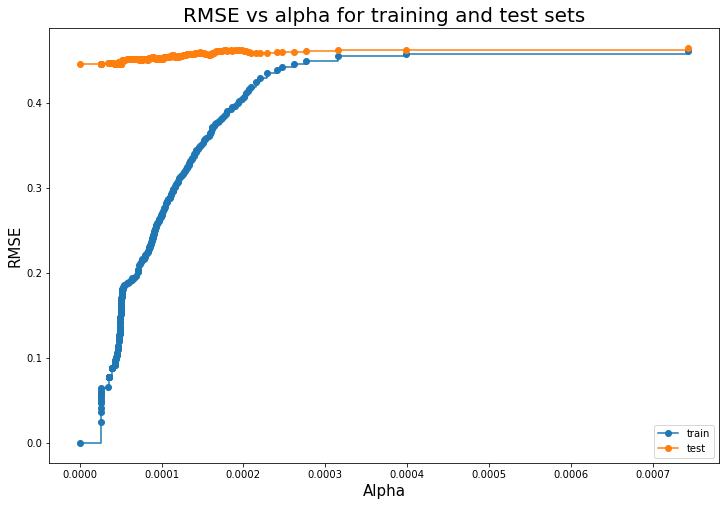

In [17]:
CART = DecisionTreeRegressor(random_state = 1, ccp_alpha = 0.0)
CART_model = CART.fit(X_train, y_train)
path = CART.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas[::5]
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeRegressor(random_state = 1, ccp_alpha = ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
test_scores = [RMSE(clf, X_test, y_test) for clf in clfs]
train_scores = [RMSE(clf, X_train, y_train) for clf in clfs]

fig, ax = plt.subplots(figsize = [12, 8])
ax.set_xlabel("Alpha", fontsize = 15)
ax.set_ylabel("RMSE", fontsize = 15)
ax.set_title("RMSE vs alpha for training and test sets", fontsize = 20)
ax.plot(ccp_alphas, train_scores, marker = 'o', label = "train", drawstyle = "steps-post")
ax.plot(ccp_alphas, test_scores, marker = 'o', label = "test", drawstyle = "steps-post")
ax.legend()
plt.show()

In [21]:
Best_CART = clfs[np.argmin(test_scores)]
print(f' ccp_alpha={Best_CART.ccp_alpha}')
print(f' depth={Best_CART.get_depth()}')
print(f' leaves={Best_CART.get_n_leaves()}')

 ccp_alpha=2.593862780452642e-05
 depth=36
 leaves=2073


In [20]:
min(test_scores)

0.4454114633273831

In [24]:
# RANDOM FOREST

Minimum for 400 trees


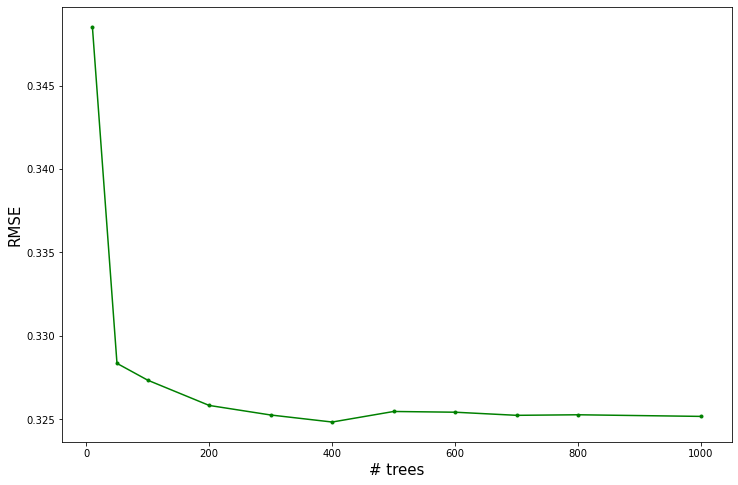

In [25]:
rfr = RandomForestRegressor
N = [10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 1000]
RMSE_RF= [RMSE(rfr(n, n_jobs = -1).fit(X_train, y_train), X_test, y_test) for n in N]
plt.figure(figsize = (12, 8))
plt.plot(N, RMSE_RF, '.-', color = 'g');
plt.xlabel("# trees", fontsize = 15)
plt.ylabel("RMSE", fontsize = 15)
print("Minimum for", N[np.argmin(RMSE_RF)], "trees")

In [26]:
#Checking number of features influence on RMSE
features = np.linspace(1, X_train.shape[1], 10).astype(int)
RMSE_RF_features= [RMSE(rfr(400, max_features = n, n_jobs = -1).fit(X_train, y_train), X_test, y_test) for n in features]

Minimum for 13 features


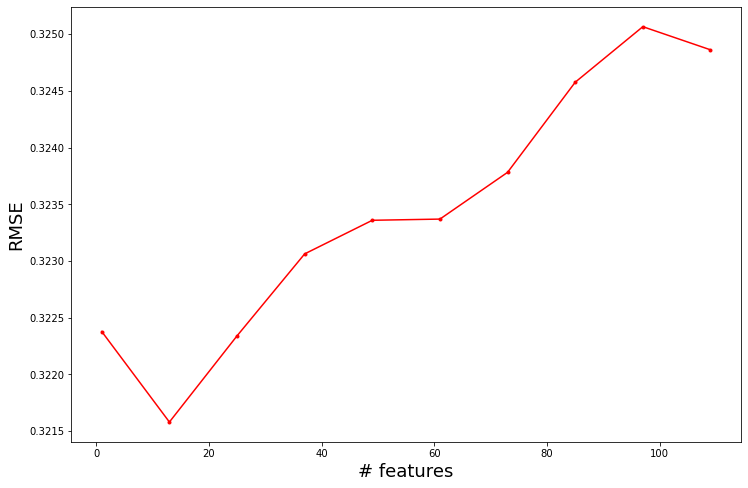

In [27]:
plt.figure(figsize = (12, 8))
plt.plot(features, RMSE_RF_features, '.-', color = 'r');
features[np.argmin(RMSE_RF_features)]
plt.xlabel("# features", fontsize = 18)
plt.ylabel("RMSE", fontsize = 18)
print("Minimum for", features[np.argmin(RMSE_RF_features)], "features")

In [40]:
Best_RF = RandomForestRegressor(400, max_features = 13, n_jobs = -1).fit(X_train, y_train)

In [101]:
RMSE(Best_RF, X_test, y_test)

0.32152603808005215

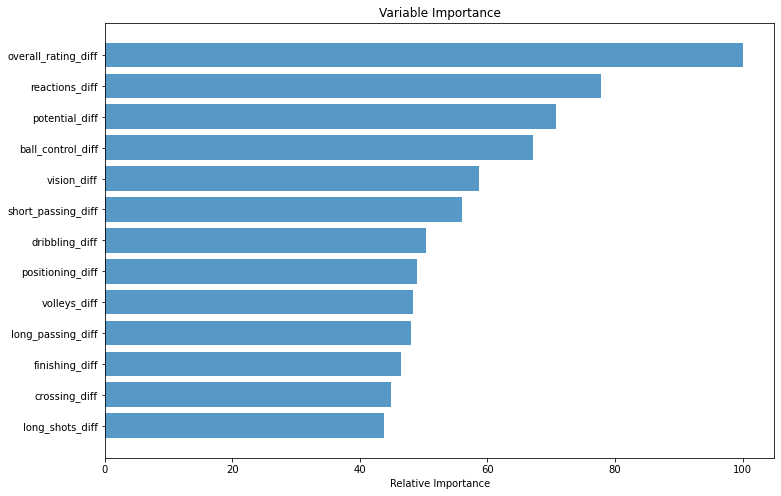

In [125]:
# Plot feature importance
feature_importance = Best_RF.feature_importances_
# Make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
num_feat = 13

plt.figure(figsize = [12, 8])
plt.barh(pos[-num_feat:], feature_importance[sorted_idx][-num_feat:], align='center', alpha = 0.75)
plt.yticks(pos[-num_feat:], X_train.columns[sorted_idx][-num_feat:])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

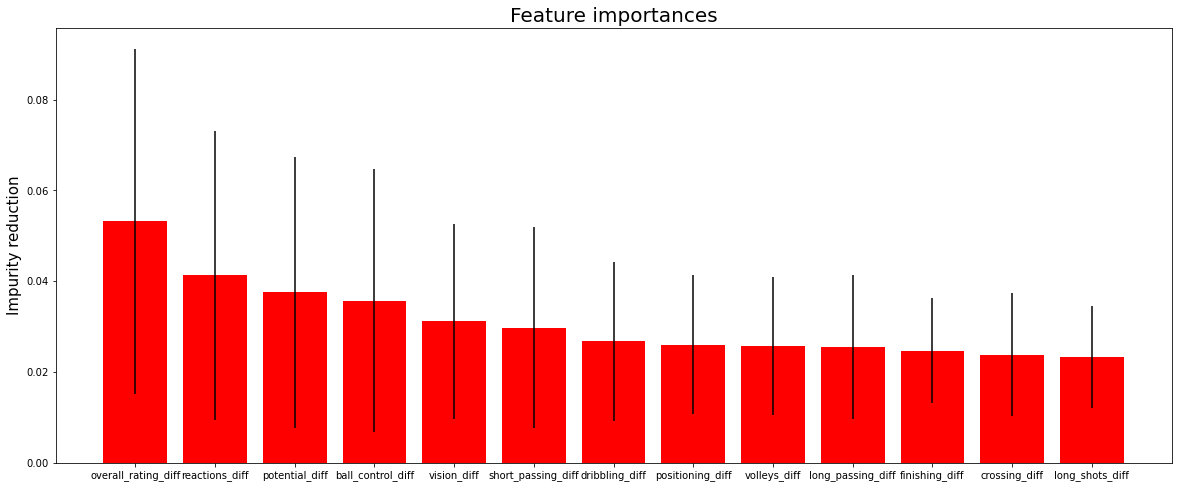

In [47]:
# Plot the feature importances of the forest
importances = Best_RF.feature_importances_
std = np.std([tree.feature_importances_ for tree in Best_RF.estimators_], axis = 0)
indices = np.argsort(importances)[::-1]

num_feat = 13
plt.figure(figsize = [20, 8])
plt.title("Feature importances", fontsize = 20)
plt.bar(range(num_feat)[:num_feat], importances[indices][:num_feat],
       color = "r", yerr = std[indices][:num_feat], align = "center")
plt.xticks(range(num_feat)[:num_feat], X_train.columns[indices[:num_feat]])
plt.xlim([-1, num_feat])
plt.ylabel("Impurity reduction", fontsize = 15)
plt.show()

In [30]:
# GRADIENT BOOSTED TREES

In [98]:
#Checking number of tress influence on RMSE
gbr = GradientBoostingRegressor
N = [10, 50, 100, 500,1000, 1500,2000,2500,3000,3500,4000,4500,5000,5500,6000,6500,7000,8000,9000,10000]
RMSE_GBT = [RMSE(gbr(n_estimators = n).fit(X_train, y_train), X_test, y_test) for n in N]

In [107]:
N_2=[22000,25000,30000,35000]

In [108]:
RMSE_GBT_2 = [RMSE(gbr(n_estimators = n).fit(X_train, y_train), X_test, y_test) for n in N_2]

In [111]:
for model in RMSE_GBT_2:
    RMSE_GBT.append(model)

for n in N_2:
    N.append(n)

In [112]:
N

[10,
 50,
 100,
 500,
 1000,
 1500,
 2000,
 2500,
 3000,
 3500,
 4000,
 4500,
 5000,
 5500,
 6000,
 6500,
 7000,
 8000,
 9000,
 10000,
 11000,
 12000,
 13000,
 14000,
 15000,
 18000,
 20000,
 22000,
 25000,
 30000,
 35000]

In [99]:
RMSE_GBT = [RMSE(gbr(n_estimators = n).fit(X_train, y_train), X_test, y_test) for n in N]

Minimum for 22000 trees


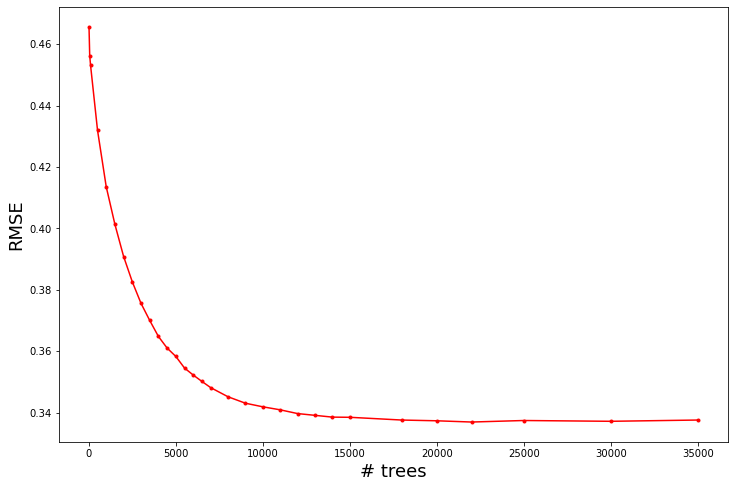

In [119]:
plt.figure(figsize = (12, 8))
plt.plot(N, RMSE_GBT, '.-', color = 'r');
plt.xlabel("# trees", fontsize = 18)
plt.ylabel("RMSE", fontsize = 18)
print("Minimum for", N[np.argmin(RMSE_GBT)], "trees")

In [114]:
Best_GBT = GradientBoostingRegressor(n_estimators = 22000).fit(X_train,y_train)

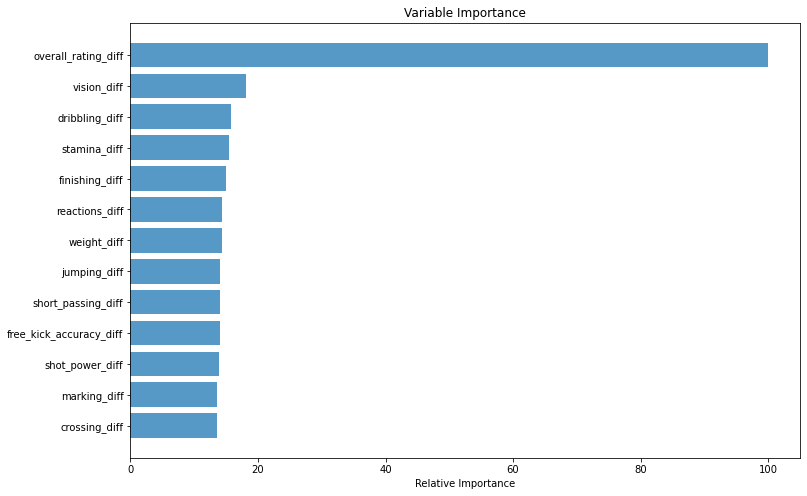

In [120]:
# Plot feature importance
feature_importance = Best_GBT.feature_importances_
# Make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
num_feat = 13

plt.figure(figsize = [12, 8])
plt.barh(pos[-num_feat:], feature_importance[sorted_idx][-num_feat:], align='center', alpha = 0.75)
plt.yticks(pos[-num_feat:], X_train.columns[sorted_idx][-num_feat:])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [121]:
# Extra Trees Classifier

In [94]:
clf = ExtraTreesClassifier()

In [95]:
param_grid = {'n_estimators': [50, 100, 200, 300,400,500],
              'max_depth': [None, 5, 10, 15,20,40],
              'min_samples_split': [2, 5, 10,15],
              'min_samples_leaf': [1, 2, 4,8,10]}

In [96]:
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5)
grid_search.fit(X, y)

GridSearchCV(cv=5, estimator=ExtraTreesClassifier(),
             param_grid={'max_depth': [None, 5, 10, 15, 20, 40],
                         'min_samples_leaf': [1, 2, 4, 8, 10],
                         'min_samples_split': [2, 5, 10, 15],
                         'n_estimators': [50, 100, 200, 300, 400, 500]})

In [97]:
print("Najlepsze hiperparametry: ", grid_search.best_params_)
print("Osiągnięta dokładność: ", grid_search.best_score_)

Najlepsze hiperparametry:  {'max_depth': 40, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Osiągnięta dokładność:  0.5800654017751732


In [116]:
BEST_ETC=ExtraTreesClassifier(max_depth=40,min_samples_leaf=1,min_samples_split=2,n_estimators=500)

In [117]:
BEST_ETC.fit(X_train,y_train)

ExtraTreesClassifier(max_depth=40, n_estimators=500)

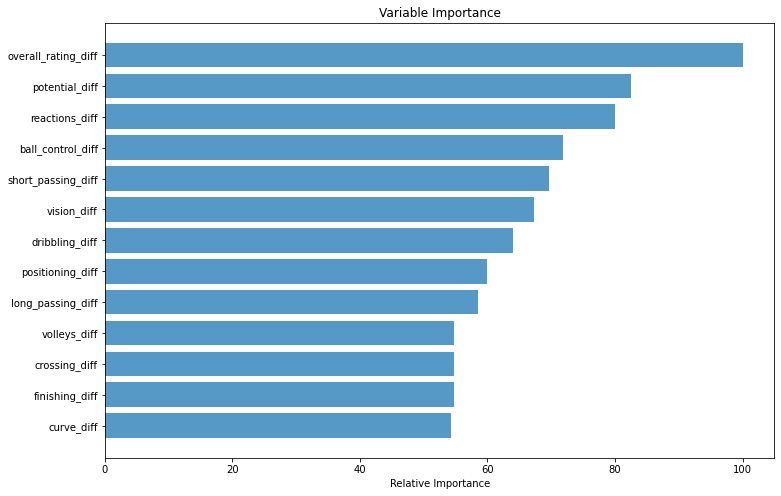

In [124]:
# Plot feature importance
feature_importance = BEST_ETC.feature_importances_
# Make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
num_feat = 13

plt.figure(figsize = [12, 8])
plt.barh(pos[-num_feat:], feature_importance[sorted_idx][-num_feat:], align='center', alpha = 0.75)
plt.yticks(pos[-num_feat:], X_train.columns[sorted_idx][-num_feat:])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [ ]:
#Porównanie rezultatów tych 4

In [126]:
models = [Best_CART, Best_RF, Best_GBT,BEST_ETC]
errors = [RMSE(m, X_test, y_test) for m in models]

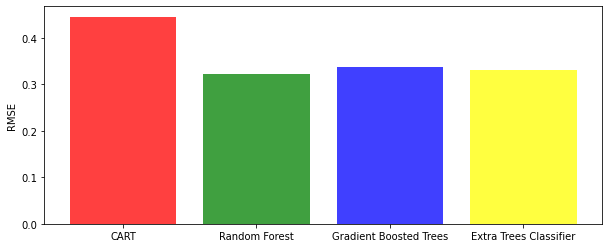

In [127]:
plt.figure(figsize = (10, 4))
plt.bar(['CART','Random Forest','Gradient Boosted Trees','Extra Trees Classifier'], errors, color = ['red', 'green', 'blue','yellow'], alpha = 0.75)
plt.ylabel('RMSE');

In [137]:
# Best_RF
rf_labels=Best_RF.predict(X_test).round()
accuracy_score(y_test,rf_labels)

0.876072094468614

In [138]:
# GB
gb_labels=Best_GBT.predict(X_test).round()
accuracy_score(y_test,gb_labels)

0.8461155997513984

In [139]:
# etc
etc_labels=BEST_ETC.predict(X_test).round()
accuracy_score(y_test,etc_labels)

0.8912367930391547